In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, LeaveOneOut
from sklearn.feature_selection import SequentialFeatureSelector

from get_data import *

### Data load

In [9]:
ds, cols_model = get_data_model_v2()
ds_municipios, mun = get_data_municipios()
ds_zonas, zonas = get_data_zonas()

Database object created
Column n_banos has more than 20% of missing values.
Column n_plazas_garaje has more than 20% of missing values.


c:\Users\ivan\Desktop\Coding\corunaRealEstateMarket\bd.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.connection)


In [4]:
cols_model.remove('direccion_x')
cols_model.remove('direccion_y')
x = ds[cols_model].drop('precio', axis=1)
y = ds['precio']/ds['tamano']

In [5]:
aux = ds[['municipio', 'precio', 'tamano']].copy()
aux['precio_m2'] = aux['precio']/aux['tamano']
df_municipio = aux.groupby('municipio').agg({'precio_m2': 'mean', 'tamano':'count'}).sort_values('precio_m2', ascending=False).reset_index()
df_municipio = df_municipio.rename(columns={'tamano':'n_viviendas'})
df_municipio['precio_m2'] = df_municipio['precio_m2'].round(2)
df_municipio[df_municipio['n_viviendas']>=5]

,municipio,precio_m2,n_viviendas
1,oleiros,10.82,83
2,a coruña,9.98,551
3,sada,8.60,24
4,culleredo,8.52,10
5,cambre,7.27,9
6,arteixo,6.57,26
7,bergondo,6.18,8


### Model: Linear reg

In [79]:
def train_model(x,y, model, n_splits=5, n_repeats=5):
    return_val = []
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
    rkf.get_n_splits(x, y)
    for i, (train_index, val_index) in enumerate(rkf.split(x)):
        x_train = x.iloc[train_index]
        y_train = y.iloc[train_index]
        x_val = x.iloc[val_index]
        y_val = y.iloc[val_index]
        model.fit(x_train, y_train)
        y_train_pred = model.predict(x_train)
        y_val_pred = model.predict(x_val)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_val = mean_absolute_error(y_val, y_val_pred) 
        return_val.append({'rmse_train': rmse_train, 'rmse_val': rmse_val, 'mae_train': mae_train, 'mae_val': mae_val})
    return return_val

#### Linear reg

Repeated CV

In [42]:
trainings = train_model(x,y, LinearRegression(), n_splits=5, n_repeats=5)
rmse_train = [x['rmse_train'] for x in trainings]
rmse_val = [x['rmse_val'] for x in trainings]
mae_train = [x['mae_train'] for x in trainings]
mae_val = [x['mae_val'] for x in trainings]

print(f'RMSE train:\t mean {np.mean(rmse_train):.2f}\t std {np.std(rmse_train):.2f}')
print(f'RMSE val:\t mean {np.mean(rmse_val):.2f}\t std {np.std(rmse_val):.2f}')
print("")
print(f'MAE train:\t mean {np.mean(mae_train):.2f}\t std {np.std(mae_train):.2f}')
print(f'MAE val:\t mean {np.mean(mae_val):.2f}\t std {np.std(mae_val):.2f}')

RMSE train:	 mean 4.14	 std 0.39
RMSE val:	 mean 4.24	 std 1.28

MAE train:	 mean 2.33	 std 0.14
MAE val:	 mean 2.45	 std 0.23


LeaveOneOut

In [25]:
trainings = train_model(x,y, LinearRegression(), n_splits=len(x), n_repeats=1)
rmse_train = [x['rmse_train'] for x in trainings]
mae_train = [x['mae_train'] for x in trainings]
errors_val = [x['mae_val'] for x in trainings]
rmse_val = np.sqrt(np.power(errors_val, 2).mean())
mae_val = np.mean(errors_val)

print(f'RMSE train:\t mean {np.mean(rmse_train):.2f}\t std {np.std(rmse_train):.2f}')
print(f'RMSE val:\t mean {np.mean(rmse_val):.2f}\t std {np.std(errors_val):.2f}')
print("")
print(f'MAE train:\t mean {np.mean(mae_train):.2f}\t std {np.std(mae_train):.2f}')
print(f'MAE val:\t mean {np.mean(mae_val):.2f}\t std {np.std(errors_val):.2f}')

RMSE train:	 mean 4.19	 std 0.02
RMSE val:	 mean 4.37	 std 3.63

MAE train:	 mean 2.33	 std 0.01
MAE val:	 mean 2.43	 std 3.63


#### Variable selection

In [26]:
def get_step_score(current_cols, new_col, x, y, model):
    cols = current_cols + [new_col]
    trainings = train_model(x[cols],y, model)
    rmse_train = [x['rmse_train'] for x in trainings]
    rmse_train = np.mean(rmse_train)
    rmse_val = [x['rmse_val'] for x in trainings]
    rmse_val = np.mean(rmse_val)
    return rmse_train, rmse_val

current_cols = []
scores_train = []
scores_val = []
cols = []
all_columns = cols_model[:]
all_columns.remove('precio')

for k in range(len(all_columns)-1):
    best_col = None
    best_score_training = 1e20
    best_score_val = 1e20
    best_model = None
    for col in set(all_columns)-set(current_cols):
        score_training, score_val = get_step_score(current_cols, col, x, y, LinearRegression())
        if score_training < best_score_training:
            best_score_training = score_training
            best_score_val = score_val
            best_col = col
    current_cols.append(best_col)
    scores_train.append(best_score_training)
    scores_val.append(best_score_val)
    cols.append(current_cols[:])
    print(f'Best column: {best_col}\t score training:{best_score_training:.2f}\t score_val:{score_val:.2f}')

Best column: n_habitaciones	 score training:4.65	 score_val:4.77
Best column: playa	 score training:4.56	 score_val:4.50
Best column: es_casa	 score training:4.50	 score_val:4.43
Best column: tamano	 score training:4.44	 score_val:4.47
Best column: sin_ascensor	 score training:4.38	 score_val:4.41
Best column: densidad	 score training:4.33	 score_val:4.34
Best column: oleiros	 score training:4.29	 score_val:4.33
Best column: estudiantes	 score training:4.25	 score_val:4.25
Best column: balcon	 score training:4.23	 score_val:4.25
Best column: estrenar	 score training:4.22	 score_val:4.27
Best column: amueblado	 score training:4.21	 score_val:4.25
Best column: vacacional	 score training:4.19	 score_val:4.30
Best column: piscina	 score training:4.17	 score_val:4.24
Best column: vistas	 score training:4.18	 score_val:4.25
Best column: coruna	 score training:4.17	 score_val:4.25
Best column: valoracion	 score training:4.17	 score_val:4.24
Best column: parking	 score training:4.16	 score_val

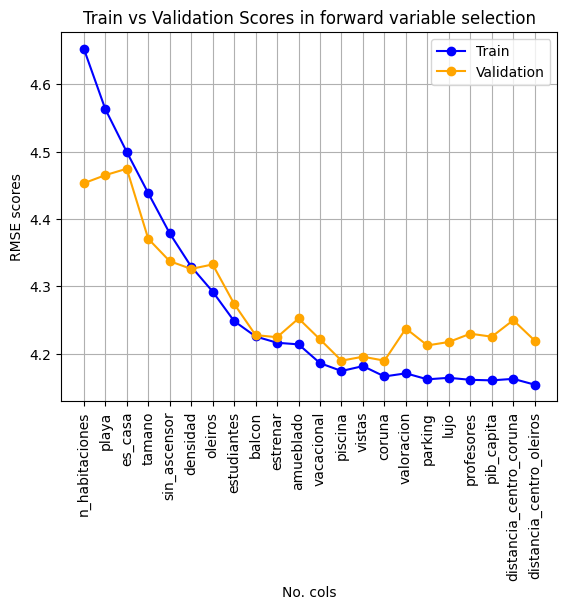

In [27]:
idx = list(range(len(current_cols)))
plt.plot(idx, scores_train, marker='o', linestyle='-', color='blue', label='Train')
plt.plot(idx, scores_val, marker='o', linestyle='-', color='orange', label='Validation')

plt.xlabel('No. cols')
plt.ylabel('RMSE scores')
plt.title('Train vs Validation Scores in forward variable selection')
plt.xticks(idx, current_cols)  # Use column names as x-axis labels
#in vertical
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

### Model: KNN

In [28]:
x_dir = ds[['direccion_x', 'direccion_y', 'tamano', 'precio', 'n_habitaciones']].copy()
x_dir['precio_m2'] = x_dir['precio']/x_dir['tamano']
x_dir = x_dir.dropna().reset_index(drop=True)
y_dir = x_dir['precio_m2']
x_dir = x_dir.drop(['precio', 'precio_m2'], axis=1)

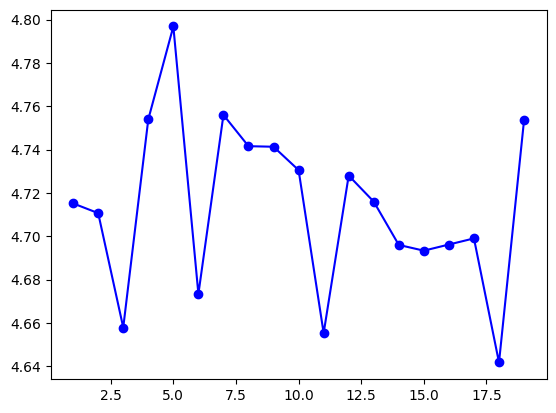

In [29]:
from sklearn.neighbors import KNeighborsRegressor

scores = []
for k in range(1,20):
    knn = KNeighborsRegressor(n_neighbors=5)
    trainings = train_model(x_dir,y_dir, knn, n_splits=5, n_repeats=5)
    rmse_train = [x['rmse_train'] for x in trainings]
    rmse_val = [x['rmse_val'] for x in trainings]
    mae_train = [x['mae_train'] for x in trainings]
    mae_val = [x['mae_val'] for x in trainings]

    # print(f'RMSE train:\t mean {np.mean(rmse_train):.2f}\t std {np.std(rmse_train):.2f}')
    # print(f'RMSE val:\t mean {np.mean(rmse_val):.2f}\t std {np.std(rmse_val):.2f}')
    # print("")
    # print(f'MAE train:\t mean {np.mean(mae_train):.2f}\t std {np.std(mae_train):.2f}')
    # print(f'MAE val:\t mean {np.mean(mae_val):.2f}\t std {np.std(mae_val):.2f}')
    scores.append(np.mean(rmse_val))

plt.plot(range(1, 20), scores, marker='o', linestyle='-', color='blue', label='Train')

### Geospatial

In [9]:
data = ds[['precio', 'direccion_x', 'direccion_y', "tamano", "n_habitaciones"]]
data = data[data['direccion_x']<43.40]
data = data[data['direccion_x']>43.30]
# data = data[data['direccion_y']<-8.35]
# data = data[data['direccion_y']>-8.45]

data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680 entries, 0 to 712
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   precio          680 non-null    float64
 1   direccion_x     680 non-null    float64
 2   direccion_y     680 non-null    float64
 3   tamano          680 non-null    float64
 4   n_habitaciones  680 non-null    float64
dtypes: float64(5)
memory usage: 31.9 KB


In [10]:
def get_zona(x, zonas, municipios):
    titulo = x['titulo'].lower()
    zona = None
    for z in zonas:
        if z in titulo:
            zona = z
            return zona
        if '-' in z:
            zn = z.split('-')
            for zi in zn:
                if zi in titulo:
                    zona = z
                    return zona
    for m in municipios:
        if m in titulo:
            zona = m
            return zona
    return None
    
def get_zona_v2(x, zonas, municipios):
    titulo = x['titulo'].lower()
    municipio = x['municipio'].lower()
    if 'coruña' in municipio or 'oleiros' in municipio:
        for z in zonas:
            if z in titulo:
                return z
        for z in zonas:
            if '-' in z:
                zn = z.split('-')
                for zi in zn:
                    zi = zi.strip()
                    if zi in titulo:
                        return z
        return municipio
    else:
        return municipio

In [11]:
df['zona'] = df.apply(lambda x: get_zona_v2(x, zonas, mun), axis=1)
viv_zonas = df.groupby('zona').agg({'titulo':'count','precio':'mean', 'precio_m2':'mean', 'tamano':'mean', 'n_habitaciones':'mean'}).reset_index()
viv_zonas = viv_zonas.rename(columns={'titulo':'n_viviendas'})
viv_zonas.sort_values('n_viviendas', ascending=False)

,zona,n_viviendas,precio,precio_m2,tamano,n_habitaciones
14,ensanche - juan florez,128,1221.859375,10.989687,119.914062,2.812500
8,cuatro caminos - plaza de la cubela,74,928.040541,9.567359,102.027027,2.810811
21,monte alto - zalaeta - atocha,71,810.492958,11.569948,74.366197,2.112676
27,riazor - los rosales,46,791.847826,9.195199,87.260870,2.586957
1,agra del orzan - ventorrillo,39,743.205128,8.563318,89.076923,3.052632
30,someso - matogrande,38,828.947368,9.403491,93.921053,2.605263
24,os mallos,36,748.472222,8.537861,90.083333,2.972222
7,ciudad vieja - centro,31,1113.580645,11.221387,102.161290,2.161290
26,perillo,31,1343.709677,11.832662,116.838710,2.870968
17,los castros - castrillon,30,707.166667,8.840640,82.533333,2.533333


C:\Users\ivan\AppData\Local\Temp\ipykernel_3776\3114051616.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('RdYlGn_r')


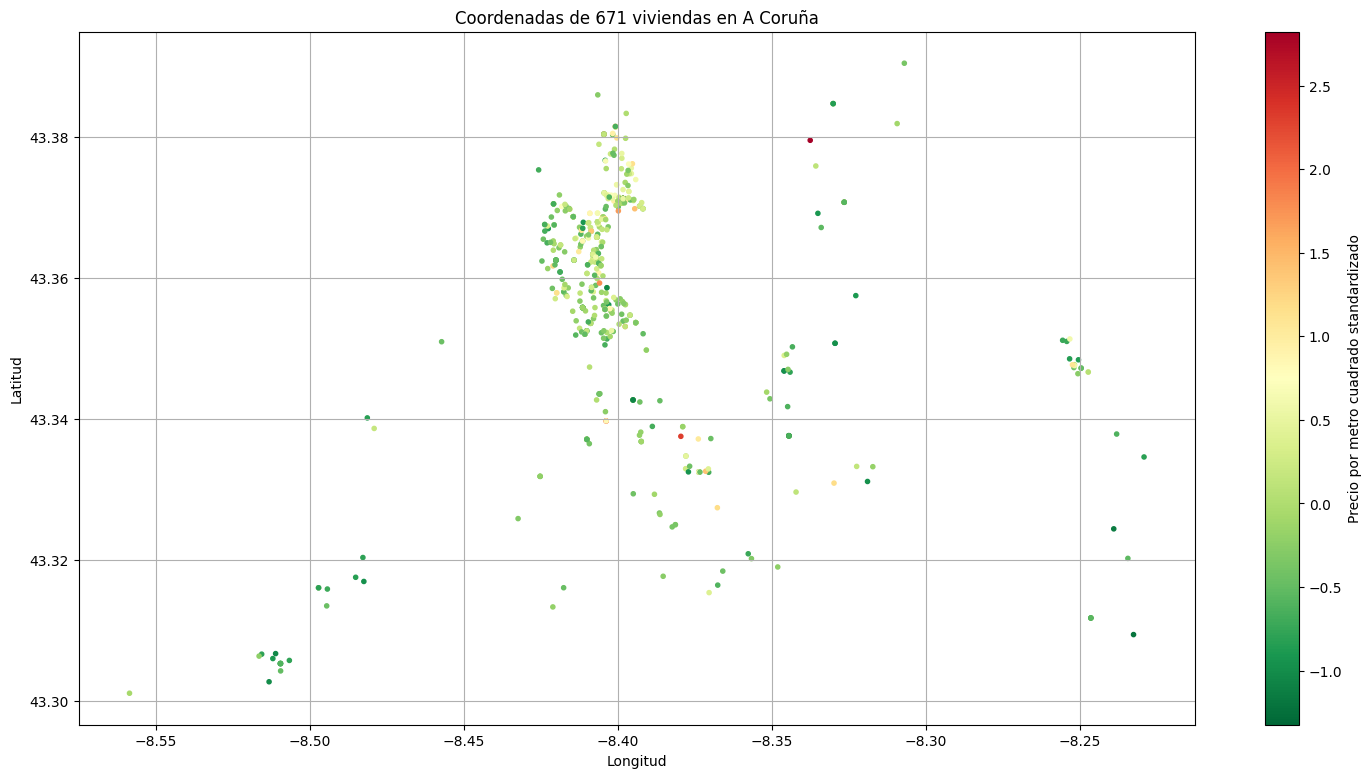

In [10]:
filter = 3
filter_left = -3

longs = np.array(data['direccion_x'].values.tolist())
lats = np.array(data['direccion_y'].values.tolist())
precio_m2 = np.array((data['precio']/data['tamano']).values.tolist())
normalized_precios = (precio_m2 - np.mean(precio_m2)) / np.std(precio_m2)

lats = lats[(np.abs(normalized_precios)<filter) & (normalized_precios>filter_left)]
longs = longs[(np.abs(normalized_precios)<filter) & (normalized_precios>filter_left)]
normalized_precios = normalized_precios[(np.abs(normalized_precios)<filter) & (normalized_precios>filter_left)]

# Define a colormap ranging from green to red
colormap = plt.cm.get_cmap('RdYlGn_r')

# Create the scatter plot
plt.figure(figsize=(18, 9))
scatter = plt.scatter(lats, longs, c=normalized_precios, cmap=colormap, marker='.')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Coordenadas de ' + str(len(lats)) + ' viviendas en A Coruña')
plt.grid(True)

# Add colorbar to indicate price range
cbar = plt.colorbar(scatter)
cbar.set_label('Precio por metro cuadrado standardizado')

plt.show()